In [1]:
!pip install -q flwr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.1/598.1 kB 10.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google-api-core 1.34.

In [2]:
!pip install -U flwr

In [13]:
# --- Imports ---
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import gc
import flwr as fl
from flwr.client import NumPyClient
from flwr.common import Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

# --- Load and prepare data ---
data = np.load("/kaggle/input/daicwoz-balanced/dataset_balanced.npz")
test_ids = np.load("/kaggle/input/daicwoz-balanced/test_ids (1).npy")

X_audio_test = data["X_audio_test"]
X_text_test = data["X_text_test"]
y_test = data["y_test"]

X_audio_dev = data["X_audio_dev"]
X_text_dev = data["X_text_dev"]
y_dev = data["y_dev"]

X_audio_train = data["X_audio_train"]
X_text_train = data["X_text_train"]
y_train = data["y_train"]

y_train = y_train.reshape(-1, 1)
y_dev = y_dev.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# --- Parameters ---
NUM_CLIENTS = 10
input_shape_audio = (378, 60)
input_shape_text = (378, 9)

# --- Build model ---
def build_model():
    input_audio = layers.Input(shape=input_shape_audio, name='mfcc_input')
    x_audio = layers.LSTM(60, return_sequences=True, recurrent_dropout=0.002)(input_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(40, return_sequences=True, recurrent_dropout=0.002)(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002)(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)

    input_text = layers.Input(shape=input_shape_text, name='text_input')
    x_text = layers.Flatten()(input_text)

    x = layers.Concatenate()([x_audio, x_text])
    x = layers.Reshape((1, -1))(x)
    x = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(2e-4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(15, activation='tanh')(x)
    x = layers.Dense(10, activation='tanh')(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs=[input_audio, input_text], outputs=output)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))
rmse.__name__ = "rmse"

def compile_model():
    model = build_model()
    model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-5),
                  loss=rmse,
                  metrics=['accuracy', 'mae', rmse])
    return model

# --- Split data across clients ---
def split_data(num_clients):
    X_audio_all = X_audio_train
    X_text_all = X_text_train
    y_all = y_train
    size = len(y_all) // num_clients
    return [
        (X_audio_all[i * size : (i + 1) * size if i != num_clients - 1 else None],
         X_text_all[i * size : (i + 1) * size if i != num_clients - 1 else None],
         y_all[i * size : (i + 1) * size if i != num_clients - 1 else None])
        for i in range(num_clients)
    ]

client_datasets = split_data(NUM_CLIENTS)
global_metrics = {"accuracy": [], "mae": [], "rmse": [], "f1_score": [], "precision": [], "recall": []}

# --- Client Definition ---
class DepressionClient(NumPyClient):
    def __init__(self, model, X_audio, X_text, y):
        self.model = model
        self.X_audio_train, self.X_audio_test, self.X_text_train, self.X_text_test, self.y_train, self.y_test = train_test_split(
            X_audio, X_text, y, test_size=0.1, random_state=42)

    def get_parameters(self, config=None):
        return self.model.get_weights()

    def set_parameters(self, parameters):
        self.model.set_weights(parameters)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.fit([self.X_audio_train, self.X_text_train], self.y_train,
                       batch_size=8, epochs=2, verbose=0, shuffle=True)
        return self.get_parameters(), len(self.y_train), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, acc, mae, rmse_val = self.model.evaluate([self.X_audio_test, self.X_text_test], self.y_test, verbose=0)
        return float(loss), len(self.y_test), {
            "accuracy": float(acc), "mae": float(mae), "rmse": float(rmse_val)}

# --- Client App ---
def client_fn(context: Context):
    partition_id = int(context.node_config.get("partition-id", 0))
    model = compile_model()
    X_audio_c, X_text_c, y_c = client_datasets[partition_id]
    return DepressionClient(model, X_audio_c, X_text_c, y_c).to_client()

client_app = fl.client.ClientApp(client_fn=client_fn)

# --- Server App (evaluation on dev set) ---
def server_fn(context: Context) -> ServerAppComponents:
    model = compile_model()

    def evaluate_fn(server_round, parameters, _config):
        model.set_weights(parameters)
        y_pred = model.predict([X_audio_dev, X_text_dev])
        y_pred_labels = (y_pred > 0.5).astype(int)

        acc = accuracy_score(y_dev, y_pred_labels)
        f1 = f1_score(y_dev, y_pred_labels)
        prec = precision_score(y_dev, y_pred_labels)
        rec = recall_score(y_dev, y_pred_labels)
        mae_val = np.mean(np.abs(y_dev - y_pred))
        rmse_val = np.sqrt(np.mean((y_dev - y_pred) ** 2))

        global_metrics["accuracy"].append(acc)
        global_metrics["mae"].append(mae_val)
        global_metrics["rmse"].append(rmse_val)
        global_metrics["f1_score"].append(f1)
        global_metrics["precision"].append(prec)
        global_metrics["recall"].append(rec)

        print(f"\n📊 Round {server_round} — Dev: Acc={acc:.4f}, F1={f1:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, MAE={mae_val:.4f}, RMSE={rmse_val:.4f}")

        tf.keras.backend.clear_session()
        gc.collect()

        return float(rmse_val), {
            "accuracy": float(acc),
            "f1_score": float(f1),
            "precision": float(prec),
            "recall": float(rec),
            "mae": float(mae_val),
            "rmse": float(rmse_val),
        }

    # ✅ Using FedAvg strategy
    strategy = FedAvg(
        fraction_fit=0.8,
        fraction_evaluate=0.5,
        min_fit_clients=NUM_CLIENTS,
        min_evaluate_clients=5,
        min_available_clients=NUM_CLIENTS,
        evaluate_fn=evaluate_fn
    )
    return ServerAppComponents(strategy=strategy, config=ServerConfig(num_rounds=5))

server_app = ServerApp(server_fn=server_fn)

# --- Backend Config ---
DEVICE = "cpu"
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# --- Run Simulation ---
run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config
)


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=23295) 2025-07-06 18:29:09.799311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=23295) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=23295) E0000 00:00:1751826549.886495   23295 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=23295) E0000 00:00:1751826549.912084   23295 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=23296) 2025-07-06 18:29:18.923169: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed

44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step

📊 Round 0 — Dev: Acc=0.4957, F1=0.5224, Prec=0.4961, Rec=0.5517, MAE=0.5004, RMSE=0.5005


INFO :      initial parameters (loss, other metrics): 0.500545859336853, {'accuracy': 0.4956896551724138, 'f1_score': 0.5224489795918368, 'precision': 0.49612403100775193, 'recall': 0.5517241379310345, 'mae': 0.5003533363342285, 'rmse': 0.500545859336853}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23297) 2025-07-06 18:29:34.962998: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(ClientAppActor pid=23294) 2025-07-06 18:29:34.945600: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step

📊 Round 1 — Dev: Acc=0.5338, F1=0.5837, Prec=0.5272, Rec=0.6537, MAE=0.4996, RMSE=0.5006


INFO :      fit progress: (1, 0.5005814433097839, {'accuracy': 0.5337643678160919, 'f1_score': 0.5837075048107762, 'precision': 0.5272305909617613, 'recall': 0.6537356321839081, 'mae': 0.49964046478271484, 'rmse': 0.5005814433097839}, 932.393726196)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step

📊 Round 2 — Dev: Acc=0.5043, F1=0.4904, Prec=0.5046, Rec=0.4770, MAE=0.4996, RMSE=0.5046


INFO :      fit progress: (2, 0.5046346187591553, {'accuracy': 0.5043103448275862, 'f1_score': 0.4903988183161005, 'precision': 0.5045592705167173, 'recall': 0.47701149425287354, 'mae': 0.49957993626594543, 'rmse': 0.5046346187591553}, 1907.4433671629995)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 4328 MiB, 5 objects, write throughput 174 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=23295) 2025-07-06 18:29:35.008052: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step

📊 Round 3 — Dev: Acc=0.5065, F1=0.4736, Prec=0.5074, Rec=0.4440, MAE=0.4986, RMSE=0.5101


INFO :      fit progress: (3, 0.5101281404495239, {'accuracy': 0.5064655172413793, 'f1_score': 0.4735632183908046, 'precision': 0.5073891625615764, 'recall': 0.44396551724137934, 'mae': 0.4985707104206085, 'rmse': 0.5101281404495239}, 2940.305039329999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step

📊 Round 4 — Dev: Acc=0.4978, F1=0.4492, Prec=0.4974, Rec=0.4095, MAE=0.4983, RMSE=0.5127


INFO :      fit progress: (4, 0.5127184391021729, {'accuracy': 0.4978448275862069, 'f1_score': 0.4491725768321514, 'precision': 0.4973821989528796, 'recall': 0.40948275862068967, 'mae': 0.4982863664627075, 'rmse': 0.5127184391021729}, 3912.033030268999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 6925 MiB, 8 objects, write throughput 212 MiB/s.
(raylet) Spilled 8656 MiB, 10 objects, write throughput 218 MiB/s.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step

📊 Round 5 — Dev: Acc=0.4957, F1=0.4375, Prec=0.4946, Rec=0.3922, MAE=0.4985, RMSE=0.5139


INFO :      fit progress: (5, 0.5138997435569763, {'accuracy': 0.4956896551724138, 'f1_score': 0.43749999999999994, 'precision': 0.4945652173913043, 'recall': 0.3922413793103448, 'mae': 0.4984651803970337, 'rmse': 0.5138997435569763}, 4898.800734055999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 4926.62s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5058658719062805
INFO :      		round 2: 0.5032610833644867
INFO :      		round 3: 0.5027233600616455
INFO :      		round 4: 0.48816256523132323
INFO :      		round 5: 0.49660170674324033
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.500545859336853
INFO :      		round 1: 0.5005814433097839
INFO :      		round 2: 0.5046346187591553
INFO :      		round 3: 0.5101281404495239
INFO :      		round 4: 0.5127184391021729
INFO :      		round 5

In [14]:
# --- Save Metrics ---
pd.DataFrame(global_metrics).to_csv("fl_global_metrics.csv", index=False)

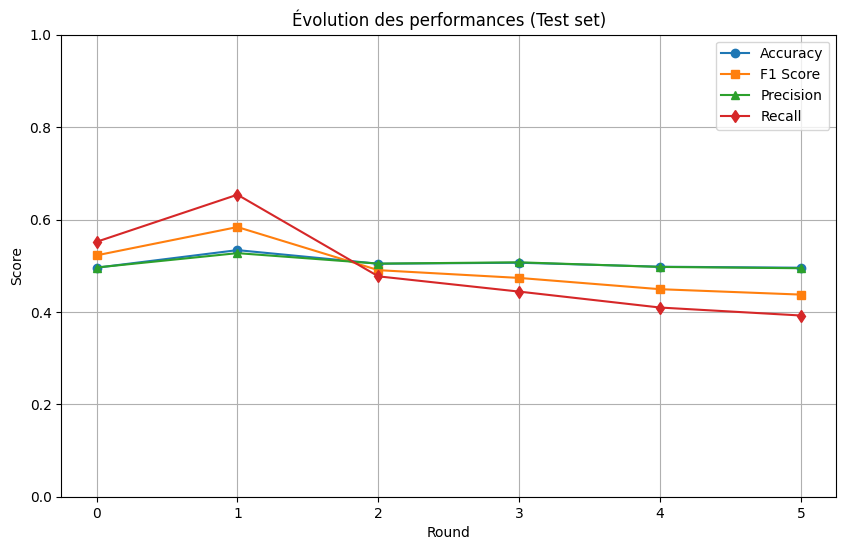

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les métriques
df = pd.read_csv("fl_global_metrics.csv")

# Tracer les courbes de performance
plt.figure(figsize=(10, 6))
plt.plot(df["accuracy"], label="Accuracy", marker="o")
plt.plot(df["f1_score"], label="F1 Score", marker="s")
plt.plot(df["precision"], label="Precision", marker="^")
plt.plot(df["recall"], label="Recall", marker="d")
plt.title("Évolution des performances (Test set)")
plt.xlabel("Round")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


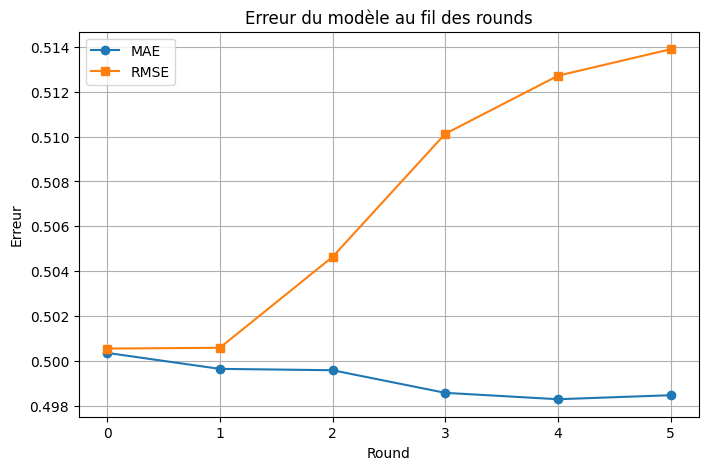

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(df["mae"], label="MAE", marker="o")
plt.plot(df["rmse"], label="RMSE", marker="s")
plt.title("Erreur du modèle au fil des rounds")
plt.xlabel("Round")
plt.ylabel("Erreur")
plt.legend()
plt.grid(True)
plt.show()


🎯 Final Evaluation on Test Set:
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step

✅ Test Accuracy: 0.4928
✅ F1 Score: 0.6038
✅ Precision: 0.4954
✅ Recall: 0.7730
✅ MAE: 0.4997
✅ RMSE: 0.5002

🧩 Confusion Matrix:
[[148 548]
 [158 538]]


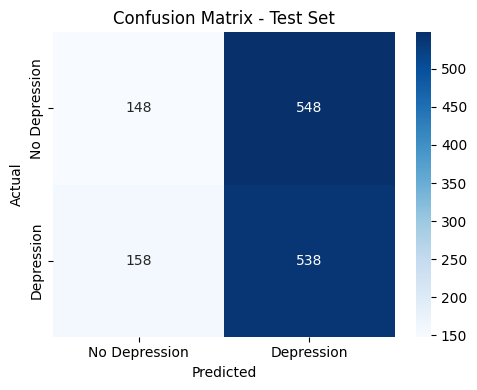

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Final Evaluation on TEST SET ---
final_model = compile_model()
# ⚠️ Replace with last global weights if saved; this is placeholder:
# final_model.set_weights(last_global_weights)

print("\n🎯 Final Evaluation on Test Set:")
y_pred_test = final_model.predict([X_audio_test, X_text_test])
y_pred_labels_test = (y_pred_test > 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred_labels_test)
f1 = f1_score(y_test, y_pred_labels_test)
prec = precision_score(y_test, y_pred_labels_test)
rec = recall_score(y_test, y_pred_labels_test)
mae_val = np.mean(np.abs(y_test - y_pred_test))
rmse_val = np.sqrt(np.mean((y_test - y_pred_test) ** 2))
cm = confusion_matrix(y_test, y_pred_labels_test)

# Display results
print(f"\n✅ Test Accuracy: {acc:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall: {rec:.4f}")
print(f"✅ MAE: {mae_val:.4f}")
print(f"✅ RMSE: {rmse_val:.4f}")
print("\n🧩 Confusion Matrix:")
print(cm)

# Optional: plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Depression", "Depression"], yticklabels=["No Depression", "Depression"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()
